# Deep Face Recognition

## Setup

### Install Dependencies

In [1]:
%pip install kagglehub


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import Dependencies

In [2]:
# Standard Dependencies
import cv2
import os
import shutil   # move data from C:\ to D:\ 
import random
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import kagglehub


# Torch Dependencies
import torch
from torch import nn
from torchinfo import summary
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics.classification import BinaryConfusionMatrix, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryAccuracy



e:\DATA SCIENCE\envs\DL_env\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup Folder Structure and Device

In [3]:
# set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make directories
if not os.path.exists(POS_PATH):
    os.makedirs(POS_PATH)
if not os.path.exists(NEG_PATH):
    os.makedirs(NEG_PATH)
if not os.path.exists(ANC_PATH):
    os.makedirs(ANC_PATH)

## Collect Data

### UnLabelled Faces in the Wild Dataset

In [ ]:
# Download the dataset
dataset_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

e:\DATA SCIENCE\envs\DL_env\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
print(dataset_path)
dataset_path = os.path.join(dataset_path, 'lfw-deepfunneled', 'lfw-deepfunneled')
print(dataset_path)

C:\Users\htc\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4
C:\Users\htc\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw-deepfunneled


In [7]:
# Move LFW Images to data/negative
for directory in os.listdir(dataset_path):
    for file in os.listdir(os.path.join(dataset_path, directory)):
        EX_PATH = os.path.join(dataset_path, directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        shutil.move(EX_PATH, NEW_PATH)

print(f"images Moved to {NEG_PATH}")


images Moved to data\negative


### Collecting Positives and Anchors

In [ ]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
# uuid?
uuid.uuid1(),uuid.uuid1()

(UUID('7369538e-1e74-11f0-b733-c025a5004cb4'),
 UUID('7369538f-1e74-11f0-8594-c025a5004cb4'))

In [60]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

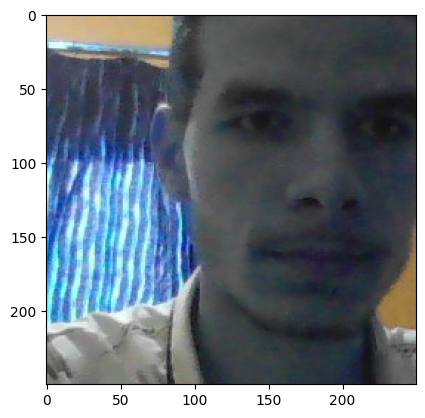

In [61]:
plt.imshow(frame)


## Process The Data

### plot some Images

In [6]:
'''
data/  
   ├── positive/  (.jpg files)  
   ├── negative/  (.jpg files)  
   └── anchor/    (.jpg files)
'''
def walk_through_dir(dir_path):
  """ Walks through dir_path returning its contents. """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    if len(dirnames) > 0:
      print (f"There are {len(dirnames)} directories in '{dirpath}'.")
    if len(filenames) > 0:
      print (f"There are {len(filenames)} images in '{dirpath}'.")

walk_through_dir("data")

There are 3 directories in 'data'.
There are 402 images in 'data\anchor'.
There are 13233 images in 'data\negative'.
There are 381 images in 'data\positive'.


Image path: data\positive\7a1a5dd0-1e77-11f0-931c-c025a5004cb4.jpg
Image class: positive
Image shape: (250, 250, 3)


(-0.5, 249.5, 249.5, -0.5)

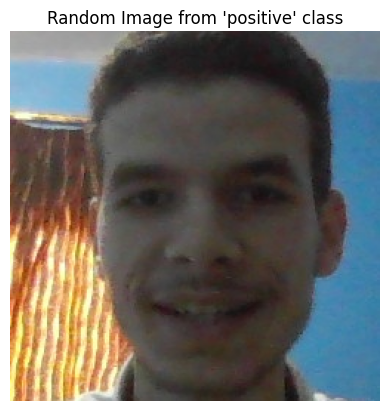

In [96]:
data_path = "data\\" + "positive"
# data_path = "data\\" + "negative"
# data_path = "data\\" + "anchor"

image_path_list = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith(".jpg")]
random_image_path = random.choice(image_path_list)

img = Image.open(random_image_path)
img_as_array = np.array(img)
image_class = os.path.basename(os.path.dirname(random_image_path))


print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image shape: {img_as_array.shape}")
plt.imshow(img_as_array)
plt.title(f"Random Image from '{image_class}' class")
plt.axis('off')

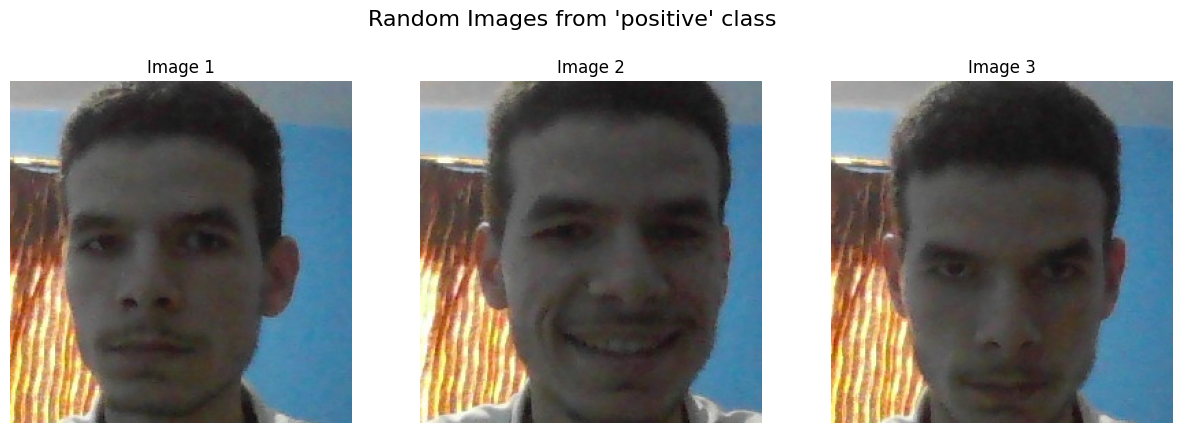

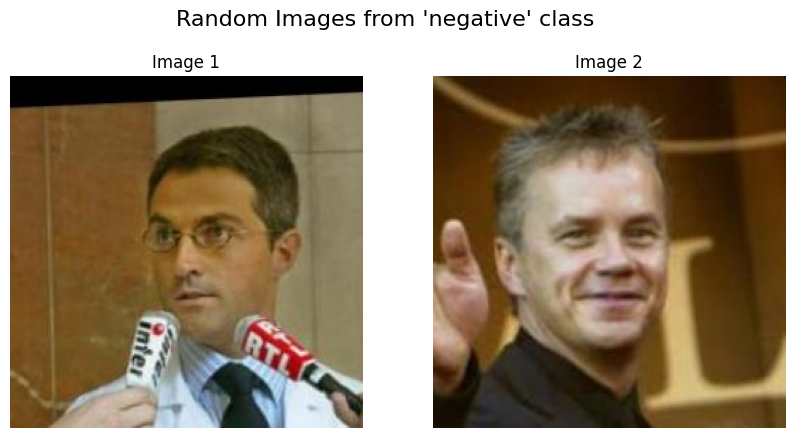

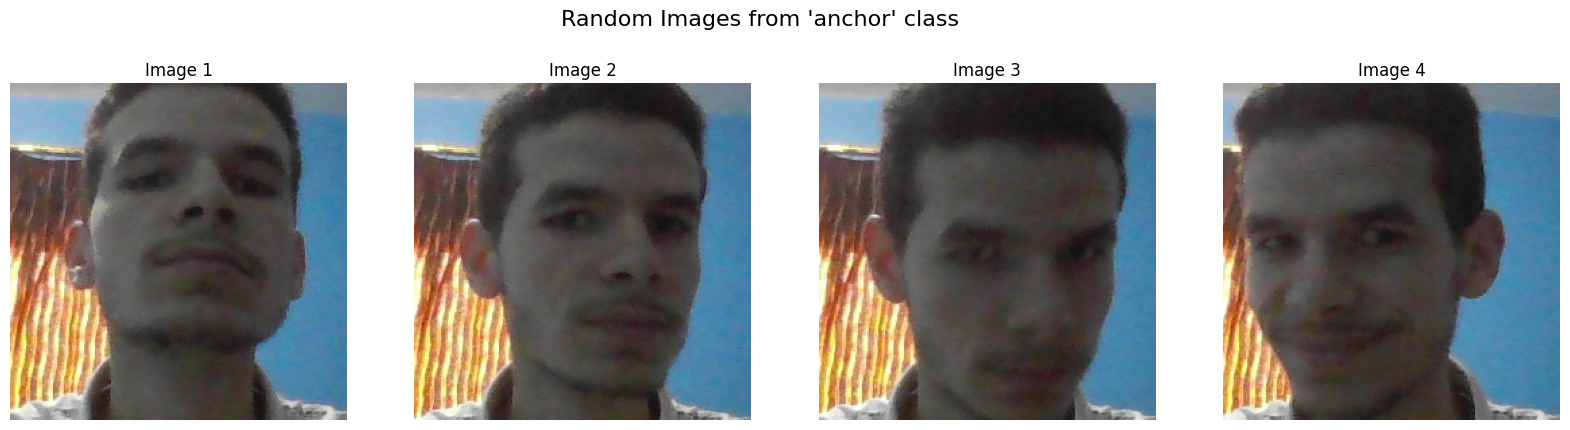

In [7]:
def plot_random_images(category, n=1):
    
    data_path = "data\\" + category

    # Get list of .jpg files in the directory
    image_path_list = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith(".jpg")]
    random_images = random.sample(image_path_list, n)
    fig, axes = plt.subplots(1, n, figsize=(n * 5, 5))  

    if n == 1:
        axes = [axes]  # If only 1 image, make sure axes is iterable

    for i, image_path in enumerate(random_images):
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis("off")

    plt.suptitle(f"Random Images from '{category}' class", fontsize=16)
    plt.show()

plot_random_images("positive", n=3)
plot_random_images("negative", n=2)
plot_random_images("anchor", n=4)

### craete Transform data

In [8]:
data_transform = transforms.Compose([
    transforms.Resize(size=(105, 105)), # resize to 105x105
    transforms.ToTensor() # convert to tensor and normalize to [0,1]
])

In [9]:
img = Image.open(random_image_path)
img_as_array = np.asarray(img)
print(f"Before Transform : {img_as_array.shape}") 
transformed_img = data_transform(img)
print(f"After Transform : {transformed_img.shape}" )

NameError: name 'random_image_path' is not defined

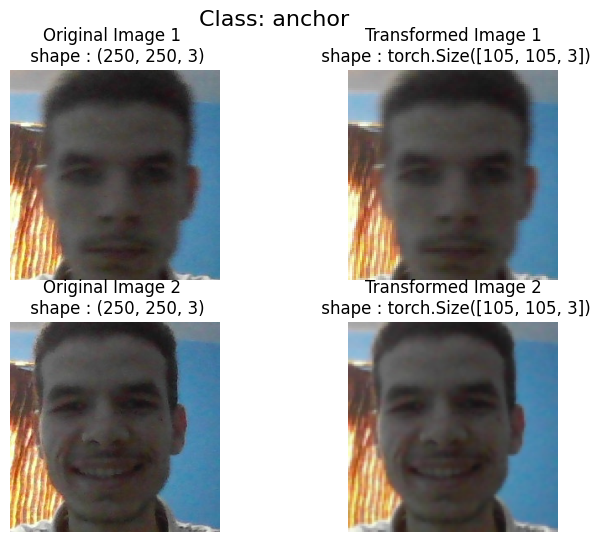

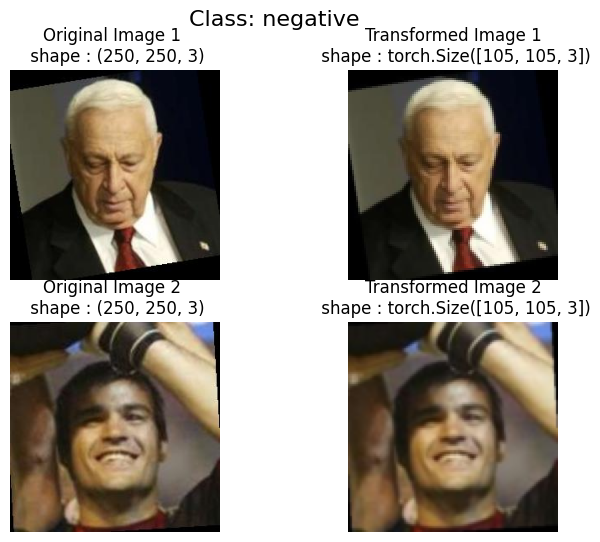

In [10]:
def plot_transformed_images(category, transform, n=3):

    data_path = "data\\" + category

    image_path_list = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith(".jpg")]

    random_image_paths = random.sample(image_path_list, k=n)

    fig, axes = plt.subplots(n, 2, figsize=(8, n * 3)) # 2 columns for original and transformed

    for i, image_path in enumerate(random_image_paths):
        img = Image.open(image_path)
        transformed_img = data_transform(img)

        fig.suptitle(f"Class: {category}", fontsize=16)

        # Original image
        image_as_numpy = np.array(img)
        axes[i, 0].imshow(image_as_numpy)
        axes[i, 0].set_title(f"Original Image {i+1} \n shape : {image_as_numpy.shape}")
        axes[i, 0].axis("off")



        # Transform and plot image
        transformed_img = transformed_img.permute(1, 2, 0)


        axes[i, 1].imshow(transformed_img)
        axes[i, 1].set_title(f"Transformed Image {i+1}\n shape : {transformed_img.shape}")
        axes[i, 1].axis("off")


        


plot_transformed_images(category="anchor",
                        transform=data_transform, 
                        n=2)
plot_transformed_images(category="negative",
                        transform=data_transform, 
                        n=2)

In [11]:
anc_files = ["a1.jpg", "a2.jpg", "a3.jpg"]
neg_files = ["n1.jpg", "n2.jpg", "n3.jpg"]
pos_files = ["p1.jpg", "p2.jpg", "p3.jpg"]
# np.zeros(3) = [0.0, 0.0, 0.0]

positives = list( zip(anc_files, pos_files, np.ones(3)) )
positives

[('a1.jpg', 'p1.jpg', 1.0),
 ('a2.jpg', 'p2.jpg', 1.0),
 ('a3.jpg', 'p3.jpg', 1.0)]

### Create Dataset class and Split into train-test

In [12]:
class DFR_Dataset(Dataset):
    def __init__(self, anc_path, pos_path, neg_path, num_samples=300, transform=data_transform):

        self.transform = transform
        self.total_length = num_samples * 2   # positives + negatives

        # List .jpg files from each directory and take num_samples
        self.anc_files = [os.path.join(anc_path, f) for f in os.listdir(anc_path) 
                            if f.endswith('.jpg')][:num_samples]
        self.pos_files = [os.path.join(pos_path, f) for f in os.listdir(pos_path) 
                          if f.endswith('.jpg')][:num_samples]
        self.neg_files = [os.path.join(neg_path, f) for f in os.listdir(neg_path) 
                          if f.endswith('.jpg')][:num_samples]

        self.positives = list(zip(self.anc_files, self.pos_files, np.ones(num_samples)))
        self.negatives = list(zip(self.anc_files, self.neg_files, np.zeros(num_samples)))

        self.data = self.positives + self.negatives

    def __len__(self):
        return self.total_length
    
    def __getitem__(self, idx):
            # Load images
            anchor_img = Image.open(self.data[idx][0]).convert('RGB')
            other_img = Image.open(self.data[idx][1]).convert('RGB')
            label = self.data[idx][2]

            # Apply transformations if specified
            if self.transform:
                anchor_img = self.transform(anchor_img)
                other_img = self.transform(other_img)

            return anchor_img, other_img, label

In [13]:
dataset = DFR_Dataset(
    anc_path=ANC_PATH,
    pos_path=POS_PATH,
    neg_path=NEG_PATH,
    num_samples=300,
    transform=data_transform
)


In [14]:
data_size = len(dataset)
print(f" data size : {data_size}")
train_size = int(data_size * 0.7)
test_size = data_size - train_size

train_dataset, test_dataset = random_split(dataset=dataset, lengths=[train_size, test_size])
print(f"Train Size: {len(train_dataset)}, Test Size: {len(test_dataset)}")

 data size : 600
Train Size: 420, Test Size: 180


In [15]:
anchor_img, other_img, label = train_dataset[0]
anchor_img.shape, other_img.shape, label

(torch.Size([3, 105, 105]), torch.Size([3, 105, 105]), 0.0)

###  Create DataLoader

In [16]:
BATCH_SIZE = 16
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000026F48A56AB0>, <torch.utils.data.dataloader.DataLoader object at 0x0000026F48AFB260>)
Length of train dataloader: 27 batches of 16
Length of test dataloader: 12 batches of 16


In [18]:
print(train_dataloader.batch_size)
print(test_dataloader.dataset)

anc_image_batch ,other_image_batch , labels_batch = next(iter(train_dataloader)) # [16, 3, 125, 125], [16, 3, 125, 125], [16]

print(f"Anchor Image Batch Shape: {anc_image_batch.shape}")
print(f"Other Image Batch Shape: {other_image_batch.shape}")
print(f"Labels Batch Shape: {labels_batch.shape}")


16
Anchor Image Batch Shape: torch.Size([16, 3, 105, 105])
Other Image Batch Shape: torch.Size([16, 3, 105, 105])
Labels Batch Shape: torch.Size([16])


## Models

### Embedding Model 

In [19]:
class Embedding(nn.Module):
    def __init__(self, in_channels=3, embedding_dim=4096):
        super().__init__()

        self.Feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=10),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2), 

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4),
            nn.ReLU()  
        )

        self.Feature_vector = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=9216, out_features=embedding_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.Feature_extractor(x)
        x = self.Feature_vector(x)
        return x


in_channels = 3
embedding_dim = 4096
embedding_model = Embedding(in_channels=in_channels, embedding_dim=embedding_dim).to(device)
embedding_model

Embedding(
  (Feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU()
  )
  (Feature_vector): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): Sigmoid()
  )
)

In [20]:
anchor_imge, val_img, label = dataset[0]
anchor_embedding = embedding_model(anchor_img.unsqueeze(0).to(device))
val_embedding = embedding_model(val_img.unsqueeze(0).to(device))
print(anchor_embedding.shape, val_embedding.shape)

torch.Size([1, 4096]) torch.Size([1, 4096])


In [21]:
summary(embedding_model, input_size=[1, 3, 105, 105])

Layer (type:depth-idx)                   Output Shape              Param #
Embedding                                [1, 4096]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 96, 96]           19,264
│    └─ReLU: 2-2                         [1, 64, 96, 96]           --
│    └─MaxPool2d: 2-3                    [1, 64, 48, 48]           --
│    └─Conv2d: 2-4                       [1, 128, 42, 42]          401,536
│    └─ReLU: 2-5                         [1, 128, 42, 42]          --
│    └─MaxPool2d: 2-6                    [1, 128, 21, 21]          --
│    └─Conv2d: 2-7                       [1, 128, 18, 18]          262,272
│    └─ReLU: 2-8                         [1, 128, 18, 18]          --
│    └─MaxPool2d: 2-9                    [1, 128, 9, 9]            --
│    └─Conv2d: 2-10                      [1, 256, 6, 6]            524,544
│    └─ReLU: 2-11                        [1, 256, 6, 6]           

### Distance Layer

In [22]:
class L1Dist(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, in_embedding, val_embedding):
        return torch.abs(in_embedding - val_embedding)    # element-wise absolute difference

l1 = L1Dist().to(device)
l1

L1Dist()

In [23]:
summary(
    l1,
    input_size=[ (1, 4096), (1, 4096) ], # anchor and validation embedding
    col_names=["input_size", "output_size", "num_params"]
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
L1Dist                                   [1, 4096]                 [1, 4096]                 --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.03

In [24]:
list(l1.parameters()) # No parameters

[]

### Siamese Model

In [25]:
class Siamese(nn.Module):
    def __init__(self, in_channels=3, embedding_dim=4096):
        super().__init__()
        self.Embedding = Embedding(in_channels=in_channels, embedding_dim=embedding_dim)
        self.L1Dist = L1Dist()
        self.Classifier = nn.Linear(in_features=4096, out_features=1)

    def forward(self, x1, x2):
        x1_embedding = self.Embedding(x1)
        x2_embedding = self.Embedding(x2)

        l1_dis = self.L1Dist(x1_embedding, x2_embedding)

        score  = self.Classifier(l1_dis) 
        return score 

in_channels=3
embedding_dim=4096
Siamese_model = Siamese(in_channels=in_channels, embedding_dim= embedding_dim).to(device)
Siamese_model

Siamese(
  (Embedding): Embedding(
    (Feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
      (10): ReLU()
    )
    (Feature_vector): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=9216, out_features=4096, bias=True)
      (2): Sigmoid()
    )
  )
  (L1Dist): L1Dist()
  (Classifier): Linear(in_features=4096, out_features=1, bias=True)
)

In [26]:
summary(
    Siamese_model,
    input_size=[ (1, 3, 105, 105), (1, 3, 105, 105) ], # anchor and validation embedding
    col_names=["input_size", "kernel_size", "output_size", "num_params"],
)

Layer (type:depth-idx)                   Input Shape               Kernel Shape              Output Shape              Param #
Siamese                                  [1, 3, 105, 105]          --                        [1, 1]                    --
├─Embedding: 1-1                         [1, 3, 105, 105]          --                        [1, 4096]                 --
│    └─Sequential: 2-1                   [1, 3, 105, 105]          --                        [1, 256, 6, 6]            --
│    │    └─Conv2d: 3-1                  [1, 3, 105, 105]          [10, 10]                  [1, 64, 96, 96]           19,264
│    │    └─ReLU: 3-2                    [1, 64, 96, 96]           --                        [1, 64, 96, 96]           --
│    │    └─MaxPool2d: 3-3               [1, 64, 96, 96]           2                         [1, 64, 48, 48]           --
│    │    └─Conv2d: 3-4                  [1, 64, 48, 48]           [7, 7]                    [1, 128, 42, 42]          401,536
│    │    

## Training

In [27]:
embedding_model = embedding_model.to(device)
Siamese_model = Siamese_model.to(device)

anchor_img, val_img, label = dataset[0]

anchor_img = anchor_img.unsqueeze(0).to(device)
val_img = val_img.unsqueeze(0).to(device)

anchor_embedding = embedding_model(anchor_img)
val_embedding = embedding_model(val_img)

print(anchor_embedding.shape, val_embedding.shape)


diff = l1(anchor_embedding, val_embedding)
print(diff.shape)

score = Siamese_model(anchor_img, val_img)
print(score, score.shape)

torch.Size([1, 4096]) torch.Size([1, 4096])
torch.Size([1, 4096])
tensor([[0.0144]], device='cuda:0', grad_fn=<AddmmBackward0>) torch.Size([1, 1])


### Setup Loss, Evaluation metrics and Optimizer

In [28]:
# Model
Siamese_model = Siamese().to(device)


# Loss function
binary_cross_loss = nn.BCEWithLogitsLoss()

# Accuracy Function
accuracy = BinaryAccuracy()

# Precision
precision = BinaryPrecision()
# Recall
recall = BinaryRecall()
# f1-score
f1_score = BinaryF1Score()

# Optimizer
optimizer = torch.optim.AdamW(params=Siamese_model.parameters(), lr=0.0001)

### Training Step

In [29]:
for batch_idx, (anchor_img, other_img, labels) in enumerate(train_dataloader):
    accuracy.to(device)
    # Move data to device
    anchor_img = anchor_img.to(device) # [16, 3, 105, 105]
    other_img = other_img.to(device)   # [16, 3, 105, 105]
    labels = labels.to(device)         # [16]

    # Forward pass
    y_train_logits = Siamese_model(anchor_img, other_img).squeeze(dim=1) # [16]
    y_train_prob = torch.sigmoid(y_train_logits) # [16]
    y_train_pred = torch.round(y_train_prob) # [16]
    print(f"y_train_pred : {y_train_pred}")

    # Calculate the loss and accuracy
    loss = binary_cross_loss(y_train_logits, labels)
    acc = accuracy(y_train_pred, labels)

    break


y_train_pred : tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', grad_fn=<RoundBackward0>)


In [30]:
# Training step function
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               acc_fn,
               device: torch.device = device):
    # put model and accuracy function on the device
    model.to(device)
    acc_fn.to(device)

    # Put model in training mode
    model.train()

    # Initialize loss and accuracy values
    train_loss, train_acc = 0, 0

    # Loop through the data loader
    for batch_idx, (anchor_img, other_img, labels) in enumerate(data_loader):
        # Move data to device
        anchor_img = anchor_img.to(device)   # [16, 3, 105, 105]
        other_img = other_img.to(device)     # [16, 3, 105, 105]
        labels = labels.to(device)           # [16]

        ###  Forward pass

        # Get the model logits -> probabilities -> predictions
        y_train_logits = Siamese_model(anchor_img, other_img).squeeze(dim=1) # [16]
        y_train_probs = torch.sigmoid(y_train_logits)                         # [16]
        y_train_pred = torch.round(y_train_probs)                             # [16]


        # Calculate the loss
        loss = loss_fn(y_train_logits, labels)
        train_loss += loss.item()

        # Calculate the accuracy
        acc = acc_fn(y_train_pred, labels)
        train_acc += acc.item()


        ###  Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate the average loss and accuracy
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc       
        

### Testing Step

In [121]:
def test_step(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              acc_fn,
              precision_fn = BinaryPrecision(),
              recall_fn = BinaryRecall(),
              f1_score_fn = BinaryF1Score(),
              device: torch.device = device):
    
    # move model and accuracy function to the device
    model.to(device)
    acc_fn.to(device)
    precision_fn.to(device)
    recall_fn.to(device)
    f1_score_fn.to(device)

    # Initialize loss and accuracy values
    test_loss, test_acc = 0, 0

    # Initialize evaluation metrics
    test_precision, test_recall, test_f1_score = 0, 0, 0

    # Put model in evaluation mode
    model.eval()
    with torch.inference_mode():
        for batch, (anchor_img, val_img, labels) in enumerate(data_loader):
            # move data to device
            anchor_img, val_img, labels = anchor_img.to(device), val_img.to(device), labels.to(device)

            ###   Forward pass

            #  Get the model logits -> probabilities -> predictions
            y_test_logits = model(anchor_img, val_img).squeeze(dim=1)
            y_test_probs = torch.sigmoid(y_test_logits) 
            y_test_preds = torch.round(y_test_probs)

            #  Calculate the loss
            loss = loss_fn(y_test_logits, labels)
            test_loss += loss.item()


            # Calculate evaluation metrics (Accuracy, precision, recall, f1-score)
            acc = acc_fn(y_test_preds, labels)
            test_acc += acc.item()

            precision = precision_fn(y_test_preds, labels)
            test_precision += precision.item()

            recall = recall_fn(y_test_preds, labels)
            test_recall += recall.item()

            f1_score = f1_score_fn(y_test_preds, labels)
            test_f1_score += f1_score.item()
        
        # Calculate the average loss, accuracy, precision, recall and f1-score
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        test_precision /= len(data_loader)
        test_recall /= len(data_loader)
        test_f1_score /= len(data_loader)
    return test_loss, test_acc, test_precision, test_recall, test_f1_score

### Training Loop

In [31]:
checkpoint_dir = r'E:\DATA SCIENCE\projects\dl\Deep-Facial-Recognition\training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

In [32]:
def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          acc_fn,
          optimizer: torch.optim.Optimizer,
          epochs: int = 5,
          device: torch.device = device,
          save_path: str = checkpoint_prefix):
    
    # Initialize results dictionary to store loss and accuracy values
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": [],
               "test_precision": [],
               "test_recall": [],
               "test_f1_score": []}
    

    # Loop through the epochs
    for epoch in tqdm(range(epochs)):

        # Train the model
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           acc_fn=acc_fn,
                                           optimizer=optimizer,
                                           device=device)
        # Test the model
        test_loss, test_acc, test_precision, test_recall, test_f1_score = test_step(
            model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device
        )

        # Print the results
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {100*train_acc:.2f}% | test loss: {test_loss:.4f} | test acc: {100*test_acc:.2f}%")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_precision"].append(test_precision)
        results["test_recall"].append(test_recall)
        results["test_f1_score"].append(test_f1_score)

        # save the model checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc
        }


        if epoch % 2 == 0:
            torch.save(checkpoint, f"{save_path}_epoch_{epoch + 1}.pth")
            print(f"Checkpoint saved for epoch {epoch + 1}\n")


    
    return results



### Train

In [90]:
EPOCHS = 10
results_dict = train(
    model=Siamese_model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=binary_cross_loss,
    acc_fn=accuracy,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    save_path=checkpoint_prefix
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.4360 | Train acc: 81.71% | test loss: 0.2053 | test acc: 96.88%


 10%|█         | 1/10 [00:08<01:12,  8.00s/it]

Checkpoint saved for epoch 1



 20%|██        | 2/10 [00:14<00:55,  6.94s/it]

Epoch: 1 | Train loss: 0.1675 | Train acc: 94.68% | test loss: 0.0990 | test acc: 97.40%
Epoch: 2 | Train loss: 0.1162 | Train acc: 98.15% | test loss: 0.0580 | test acc: 100.00%


 30%|███       | 3/10 [00:21<00:48,  6.90s/it]

Checkpoint saved for epoch 3



 40%|████      | 4/10 [00:27<00:39,  6.54s/it]

Epoch: 3 | Train loss: 0.0689 | Train acc: 99.54% | test loss: 0.0476 | test acc: 98.96%
Epoch: 4 | Train loss: 0.0647 | Train acc: 98.84% | test loss: 0.0637 | test acc: 99.48%


 50%|█████     | 5/10 [00:34<00:33,  6.72s/it]

Checkpoint saved for epoch 5



 60%|██████    | 6/10 [00:40<00:26,  6.64s/it]

Epoch: 5 | Train loss: 0.0551 | Train acc: 99.54% | test loss: 0.0230 | test acc: 100.00%
Epoch: 6 | Train loss: 0.0263 | Train acc: 100.00% | test loss: 0.0138 | test acc: 100.00%


 70%|███████   | 7/10 [00:47<00:20,  6.80s/it]

Checkpoint saved for epoch 7



 80%|████████  | 8/10 [00:53<00:13,  6.55s/it]

Epoch: 7 | Train loss: 0.0157 | Train acc: 100.00% | test loss: 0.0129 | test acc: 100.00%
Epoch: 8 | Train loss: 0.0132 | Train acc: 100.00% | test loss: 0.0100 | test acc: 100.00%


 90%|█████████ | 9/10 [01:00<00:06,  6.67s/it]

Checkpoint saved for epoch 9



100%|██████████| 10/10 [01:06<00:00,  6.67s/it]

Epoch: 9 | Train loss: 0.0099 | Train acc: 100.00% | test loss: 0.0084 | test acc: 100.00%


### Evaluate the Model

In [34]:
# random.seed = 42
test_samples = []
test_labels = []
for in_sample, val_sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append((in_sample, val_sample))
    test_labels.append(label)

test_samples[0][0].shape

torch.Size([3, 105, 105])

### make Prediction Function

In [ ]:
def make_predictions(model: nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            in_sample = torch.unsqueeze(sample[0], dim=0).to(device)
            val_sample = torch.unsqueeze(sample[1], dim=0).to(device)

            # Forward pass (model outputs)
            pred_logits = model(in_sample, val_sample)

            # GGet prediction probabilities (logits -> probabilities)
            pred_prob = torch.sigmoid(pred_logits.squeeze())

            # Get pred_prob off the GPU
            pred_probs.append(pred_prob.cpu())
    
    # Stack the pre_probs to turn  list into a tensor
    return torch.stack(pred_probs)

# Make predictions
pred_probs = make_predictions(model=Siamese_model,
                              data=test_samples,
                              device=device)

# View the first two prediction probabilities
pred_probs[:2]

tensor([9.9999e-01, 5.5035e-08])

In [42]:
pred_classes = torch.round(pred_probs).type(torch.int)
pred_classes

tensor([1, 0, 0, 1, 1, 0, 1, 0, 0], dtype=torch.int32)

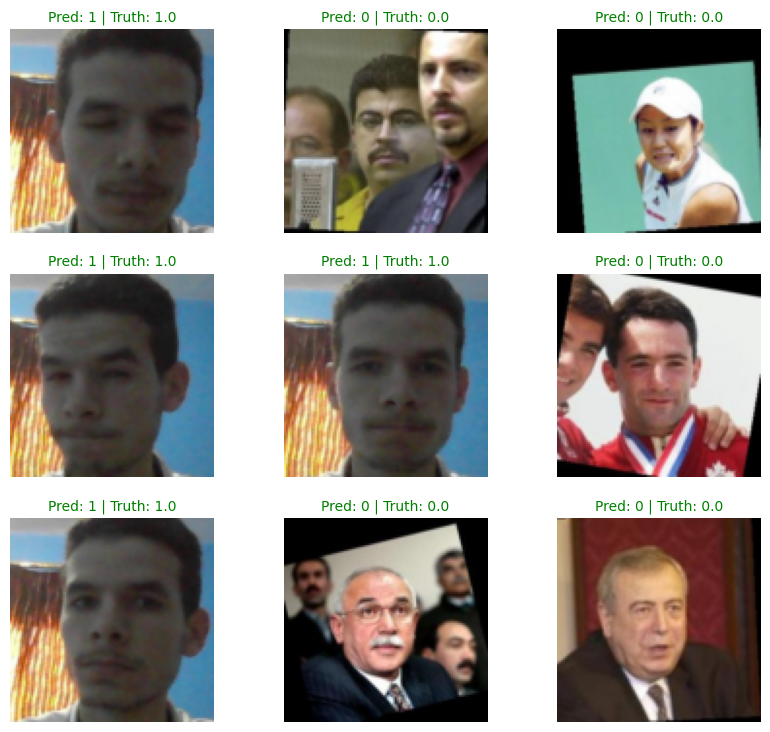

In [43]:
# Plot predictions
plt.figure(figsize=(10, 9))
nrows, ncols = 3, 3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the image
    plt.imshow(sample[1].permute(1, 2, 0))

    # Find the prediction label
    pred_label = pred_classes[i]

    # Find the truth label
    truth_label = test_labels[i]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')

    plt.axis(False)

## Save the Model

In [ ]:
# Save the model state dict
MODEL_SAVE_PATH = "model/siamese_model_weights.pth"
torch.save(Siamese_model.state_dict(), MODEL_SAVE_PATH)

In [40]:
torch.manual_seed = 42

# Load the model state dict
loaded_model = Siamese()  
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.to(device)  # Move to device
loaded_model.eval()  # Set to eval mode

C:\Users\htc\AppData\Local\Temp\ipykernel_13896\3429554842.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))


Siamese(
  (Embedding): Embedding(
    (Feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
      (10): ReLU()
    )
    (Feature_vector): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=9216, out_features=4096, bias=True)
      (2): Sigmoid()
    )
  )
  (L1Dist): L1Dist()
  (Classifier): Linear(in_features=4096, out_features=1, bias=True)
)

## Real Time Test

### Setup Paths and Folders 

In [44]:
torch.random.manual_seed(42)
# Setup paths for input image and verification images
INPUT_IMAGE_PATH = os.path.join('application_data', 'input_image')
VERIFICATION_IMAGES_PATH = os.path.join('application_data', 'verification_images')


# Make directories if they don't exist
if not os.path.exists(INPUT_IMAGE_PATH):
    os.makedirs(INPUT_IMAGE_PATH)
if not os.path.exists(VERIFICATION_IMAGES_PATH):
    os.makedirs(VERIFICATION_IMAGES_PATH)
    

positive_images_path_list = [os.path.join(POS_PATH, f) for f in os.listdir(POS_PATH) if f.endswith(".jpg")]

# Randomly select an 50 image from the positive images path list
positive_images_path_list = random.sample(positive_images_path_list, k=50)

# copy the images to the verification images path
for image_path in positive_images_path_list:
    shutil.copy(image_path, VERIFICATION_IMAGES_PATH)
print(f"images copied to {VERIFICATION_IMAGES_PATH}")


images copied to application_data\verification_images


### Verification Function

In [45]:
def process(image_path):
    img = Image.open(image_path).convert("RGB")
    transformed_image = data_transform(img) 
    return transformed_image.to(device)  # [3, 105, 105]

In [46]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []

    # Loop through the verification images
    for image_path in os.listdir(VERIFICATION_IMAGES_PATH):

        # Read the verification image and input image and process them (resize, normalize and convert to tensor)
        verification_image_path = os.path.join(VERIFICATION_IMAGES_PATH, image_path)  
        input_image_path   = os.path.join(INPUT_IMAGE_PATH, 'input_image.jpg')            
        verification_image = process(verification_image_path)
        input_image = process(input_image_path)
   
        # Make predictions
        data=[(verification_image, input_image)] # [ (verification_image, input_image) ] 
        pred_probs = make_predictions(model=loaded_model,
                                    data=data,
                                    device=device)
        results.append(pred_probs.item())
    
    # calculate the detection results and verification results
    detection_results = sum (np.array(results) > detection_threshold)
    verification_results = detection_results / len(results)
    verified = verification_results > verification_threshold

    return results, verified



### OpenCV Real Time Verification

In [47]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join(INPUT_IMAGE_PATH, 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(loaded_model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
True
True
False
True
True
False
False
True
True
